# Домашнее задание

### МОВС. 2025-2026

### Анализ временных рядов

__Выдано:__ 02.12.2025

__Срок сдачи:__ 16.12.2025 23:59 MSK

```
Обратите внимание, что если у ассистента возникают подозрения по честному выполнению заданий (плагиат или использование LLM без указания промпта), то он может поставить вам устное собеседование по проделанной работе, по итогам которого он вправе обнулить вам работу.
```

В общем, когда вы читерите, то заставляете в мире плакать одного котенка и одного ассистента. Пожалейте их.

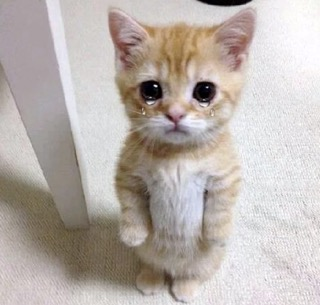

А теперь после такой грозной ноты — к более приятному.

Мы постарались составить домашнее задание так, чтобы оно помогло закрепить все то, что мы прошли на первых занятиях, посвященных классическим методам прогнозирования временных рядов. А также узнать пару новых сюжетов.

Сейчас мы будем работать со сгенерированным временным рядом, истинную форму которого вы не знаете, а мы знаем. Это все равно не значит, что мы будем знать, как построить идеальную модель (потому что в ряде есть артефакты, которые ни ETS-модель, ни SARIMA-модель не смогут до конца хорошо учесть), но мы сможем примерно оценить, а те ли компоненты и свойства ряда вы смогли примерно найти.

В бонусной части вы сможете поработать с реальным рядом и понять, насколько это больнее (а может и нет) :)

Также парочка бонусов будет раскидана по заданиям в основной части. Без бонусов можно набрать максимум 10 баллов, с бонусами — 15. При этом бонусы в сумме дают больше 5 баллов — вы можете выбирать, какие из них делать, а какие нет.

In [3]:
import random
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

### Задание 1. Первичный анализ данных (1 балл)

Для оценки качества прогнозирования будем использовать метрики MAE и MASE.

`Ответьте на вопрос (0.1 балл):` Что показывает метрика MASE и в чем ее отличие от просто MAE? В каких случаях ее использование предпочтительнее?

Мы уже с вами имплементировали метрики на одном из занятий, так что давайте просто их заберем оттуда.

1) MASE это относительная метрика, которая показывает насколько одна модель лучше чем другая(наивный прогноз). В числителе используются метрика MAE нашей новой модели, в знаменателе mae наивной модели на трейн выборке сдвинутой на период сезонности. Она  симметричная, не нужно стандатизировать данные для ее расчета. Но ее тяжело интерпретировать для бизнеса

In [5]:
def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    """MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    Args:
        forecast: Forecast values. Shape: batch, time_o
        insample: Insample values. Shape: batch, time_i
        outsample: Target values. Shape: batch, time_o
        frequency: Frequency value
    Returns:
        Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(
        np.abs(insample[:-frequency] - insample[frequency:])
    )

#### Задание 1.1: Загрузка данных (0 баллов)

Подгрузите данные.

In [74]:
url = "https://raw.githubusercontent.com/elineii/HSE-Time-Series-2025/main/HW_1/synthetic_ts.csv"

df = pd.read_csv(url)


In [76]:
df.head()

,date,y
0,2000-01-31,10.000000
1,2000-02-29,9.709006
2,2000-03-31,13.652092
3,2000-04-30,15.152031
4,2000-05-31,9.847677


#### Задание 1.2: Типы данных (0.05 балла)

Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, а значения — float. Если это не так, то исправьте их.

In [77]:
df.head(1)

,date,y
0,2000-01-31,10.0


In [78]:
df.dtypes # Данные некорректнные, переведем в нужный формат дату 

date     object
y       float64
dtype: object

In [79]:
df['date'] = pd.to_datetime(df['date'])

#### Задание 1.3: Пропуски (0.05 балла)

Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом.

In [80]:
def isna(df: pd.DataFrame, cols: list) -> bool:
    for col in cols:
        if df[col].isna().sum() == True:
            print(col, df[col].isna().sum())
        else:
            print(col, "пропущенных значений нет")


In [81]:
isna(df, df.columns)

date пропущенных значений нет
y пропущенных значений нет


#### Задание 1.4: Визуальный анализ временных рядов (0.7 балла)

Постройте линейные графики временного ряда. По оси X отложите время, по оси Y — значения временного ряда.

In [85]:
df.head(2)

,date,y
0,2000-01-31,10.000000
1,2000-02-29,9.709006


In [87]:
px.line(df, x='date', y='y', title='Синтетический временной ряд')

`Ответьте на следующие вопросы:`
- Какова частотность (frequency) данных?
- Стационарен ли временной ряд? Если нет, то какие признаки нестационарности вы можете выделить?

1) Месячная частота 
2) Ряд нестационарен - тренд, сезонность, дисперсия колебаний увеличивается со временем. 

In [ ]:
# проведем тесты стационарности Фуллера и KPSS
from statsmodels.tsa.stattools import adfuller, kpss   
result_adf = adfuller(df['y'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])



result_kpss = kpss(df['y'])
print('KPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])   

# Согласно статистике ADF ряд нестационарен (p-value > 0.05), согласно KPSS - нестационарен (p-value < 0.05).

ADF Statistic: -1.1820650211210584
p-value: 0.681262915569179
KPSS Statistic: 2.796207440165898
p-value: 0.01


C:\Users\Ivan\AppData\Local\Temp\ipykernel_2836\788348564.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Теперь постройте графики [автокорреляций (ACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) и [частных автокорреляций (PACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html) до 40-го лага для тренировочной выборки.

In [103]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\Ivan\AppData\Local\Temp\ipykernel_2836\3746707388.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



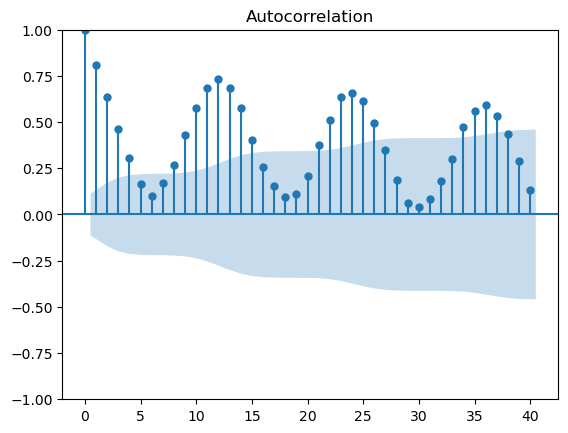

In [101]:
plot_acf(df['y'], lags=40).show()

C:\Users\Ivan\AppData\Local\Temp\ipykernel_2836\3093003852.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



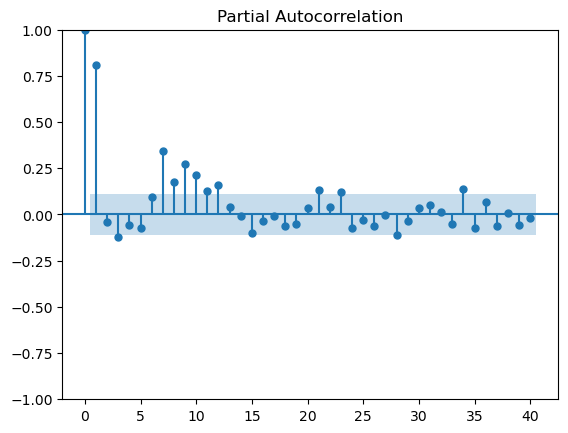

In [102]:
plot_pacf(df['y'], lags=40, method='ywm').show()

`Ответьте на следующие вопросы:`
- Стационарен ли временной ряд?
- Присутствует ли в нём тренд? Сезонность? Цикличность?
- Если ряд сезонный, то какой период выглядит наиболее вероятным? Можем ли мы сказать, что сезонность аддитивная? Мультипликативная?

1. Нестационарный ряд
2. Тренд, сезонность присутствует (видно, по пикам на ACF, при это она не постоянна, то есть со временем меняется амплитуда колебаний)
3. 12, мульпликативная 

#### Задание 1.5: Выделение тестовой выборки (0.1 балл)

Выделите 10% данных для теста, а остальные 90% оставьте для обучения.

`Ответьте на вопрос:` В чем особенность выделения тестовой выборки в задаче прогнозирования временных рядов?

1) Нельзя делать шафл, так как структура испортится последовательность временного ряда 
2) Когда много временных рядов, то нужно обязательно делить по времени, обычный трейн тест разделит по id и мы получим dataleak

In [122]:
n = len(df)
split = int(0.9 * n)

df_train = df.iloc[:split]
df_test  = df.iloc[split:]

In [148]:
df_train.tail(1)

,date,y
269,2022-06-30,27.409964


In [127]:
df_test.head(1)

,date,y
270,2022-07-31,21.296147


### Задание 2. Стабилизация дисперсии временного ряда (2 балла + 1 бонусный балл)

На одном из занятий мы с вами обсуждали, что для стабилизации дисперсии временного ряда можно использовать преобразование Box-Cox. Давайте разберемся как оно работает. Помним, что Box-Cox нельзя использовать для отрицательных значений, но у нас их и нет.

#### Задание 2.1: Имплементация Box-Cox (1 балл)

Реализуйте прямую и обратную трансформацию Box-Cox (пользоваться готовым решением нельзя!). 

Прямое преобразование Box–Cox:

$$
z = g(y;\lambda) =
\begin{cases}
\dfrac{y^{\lambda} - 1}{\lambda}, & \lambda \ne 0, \\[6pt]
\log y, & \lambda = 0.
\end{cases}
$$

Обратное преобразование Box–Cox:

$$
y = g^{-1}(z;\lambda) =
\begin{cases}
(\lambda z + 1)^{1/\lambda}, & \lambda \ne 0, \\[6pt]
e^{z}, & \lambda = 0.
\end{cases}
$$


`БОНУС (1 балл):` Выведите формулы для обратного преобразования Box-Cox. Можно прикрепить к домашнему заданию файл с решением. Или сюда фотку. Или же ЗаТеХаТь.

In [128]:
def box_cox(x: np.ndarray, lam: float) -> np.ndarray:
    if lam == 0:
        return np.log(x)
    else:
        return (np.power(x, lam) - 1) / lam
    

    

def inv_box_cox(y: np.ndarray, lam: float) -> np.ndarray:
    if lam == 0:
        return np.exp(y)
    else:
        return np.power((y * lam) + 1, 1 / lam)
    

Проверьте, что `(inv_box_cox(box_cox(x, lam), lam))` примерно восстанавливает исходный массив x.

In [133]:
df_train.head(10)

,date,y
0,2000-01-31,10.000000
1,2000-02-29,9.709006
2,2000-03-31,13.652092
3,2000-04-30,15.152031
4,2000-05-31,9.847677
5,2000-06-30,9.291575
6,2000-07-31,9.842324
7,2000-08-31,8.101826
8,2000-09-30,7.448318
9,2000-10-31,6.316688


In [134]:
lam = 1
inv_box_cox(box_cox(df_train['y'], lam), lam)

0      10.000000
1       9.709006
2      13.652092
3      15.152031
4       9.847677
         ...    
265    31.146480
266    30.986274
267    32.749186
268    30.450825
269    27.409964
Name: y, Length: 270, dtype: float64

#### Задание 2.2: Подбор параметра λ (1 балл)

Перебор параметры $\lambda$ в боевых условиях происходит с помощью максимизации логарифма правдоподобия ([The optimal lambda parameter for minimizing skewness is estimated on each feature independently using maximum likelihood](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)). 

Но давайте пойдем более простым путем: переберите 3-4 значения $\lambda$ в диапазоне от -2 до 2. Постройте графики полученных рядов и визуально оцените, при каком $\lambda$ дисперсия выглядит наиболее стабильной. 

Переберите еще несколько значений $\lambda$ рядом с тем, которое показалось вам лучшим.

`Ответьте на вопрос:` Как $\lambda$ влияет на вид преобразованного ряда?

С увеличением - увеличивается разброс, с уменьшением - уменьшается разброс.

In [143]:
for lam in np.arange(-2, 2, 0.5):
    transformed = box_cox(df_train['y'], lam)
    px.line(x=df_train['date'], y=transformed, title=f'Box-Cox Transformation with lambda={lam}').show()


`Бонус (1 балл):` Предложите и реализуйте автоматический подбор параметра $\lambda$ (не обязательно с помощью максимизации логарифма правдоподобия). Для получения полного балла оно должно показать результат не хуже подобранной $\lambda$ на глаз.

Сохраните для последующих заданий и исходный ряд, и преобразованный рядом с оптимальным $\lambda$.

In [236]:
df['y_box_cox'] = box_cox(df['y'], lam=0.5)

In [237]:
n = len(df)
split = int(0.9 * n)

df_train = df.iloc[:split]
df_test  = df.iloc[split:]

### Задание 3. STL + простые модели (1.5 балла)

#### Задание 3.1: STL-декомпозиция (0.5 балла)

Примените STL-декомпозицию к преобразованному ряду, чтобы выделить тренд, сезонность и остатки (здесь можно воспользоваться [готовым методом](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)).

Постройте графики для каждого из выделенных компонентов. 

In [239]:
df

,date,y,box_cox,y_box_cox
0,2000-01-31,10.000000,4.324555,NaN
1,2000-02-29,9.709006,4.231856,NaN
2,2000-03-31,13.652092,5.389748,NaN
3,2000-04-30,15.152031,5.785122,NaN
4,2000-05-31,9.847677,4.276202,NaN
...,...,...,...,...
295,2024-08-31,20.793163,7.119904,NaN
296,2024-09-30,18.855364,6.684553,NaN
297,2024-10-31,16.423535,6.105192,NaN
298,2024-11-30,13.990084,5.480664,NaN


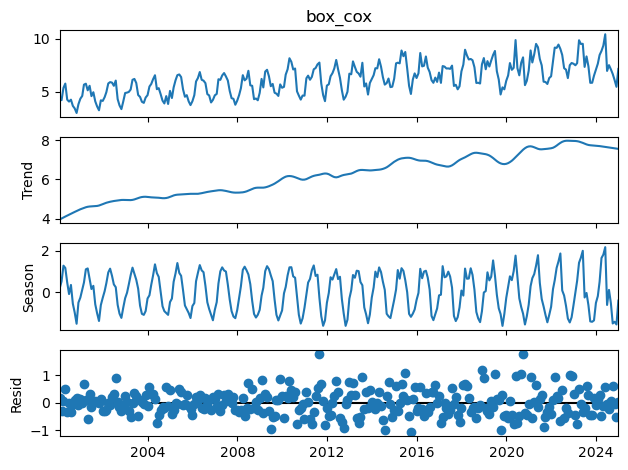

In [240]:
from statsmodels.tsa.seasonal import STL

y = df['box_cox']
y.index = pd.to_datetime(df['date'])

stl = STL(y, period=12)
res = stl.fit()

res.plot()
None


`Ответьте на вопросы:` 
- Получилось ли выделить тренд и сезонность? Похожи ли остатки на шум? 

Сезонность и тренд получилось выделить. 

Что мы можем сказать о стационарности остатков? Подтвердите соответствующими [тестами](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html). Сделайте выводы.

In [245]:
 # Взяли код из документации либы statsmodels


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [246]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [247]:
print(adf_test(res.resid))
print(' ------------------')
print(kpss_test(res.resid))

# Согласно статистике ADF остатки стационары (p-value < 0.05), согласно KPSS - стационарны (p-value > 0.05).

Results of Dickey-Fuller Test:
Test Statistic                -9.374545e+00
p-value                        7.226251e-16
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64
None
 ------------------
Results of KPSS Test:
Test Statistic            0.022487
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


C:\Users\Ivan\AppData\Local\Temp\ipykernel_2836\11026176.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Что мы можем сказать об автокорреляции остатков? Постройте ACF и PACF для остатков. Сделайте выводы.

C:\Users\Ivan\AppData\Local\Temp\ipykernel_2836\1908642968.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



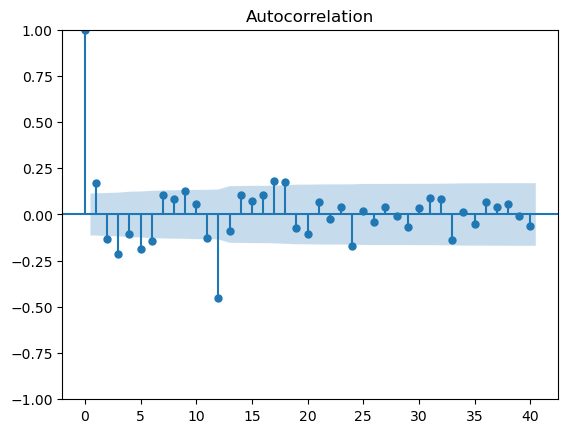

In [248]:
plot_acf(res.resid, lags=40).show()




C:\Users\Ivan\AppData\Local\Temp\ipykernel_2836\2128744933.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



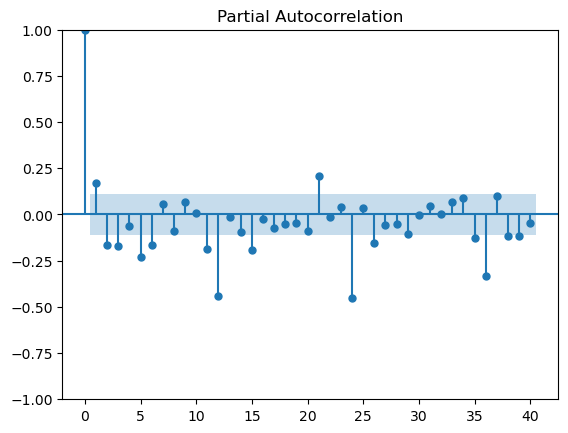

In [249]:
plot_pacf(res.resid, lags=40).show()

In [193]:
# Остатки не имеют значимых автокорреляций. Тренд и сезонность успешно удалены. Модель STL подходит для данного ряда.

#### Задание 3.2: Прогнозирование с помощью простых моделей (1 балл)

Давайте теперь построим свой первый бейзлайн. Для тренда возьмем модель Хольта, для сезонности — наивный сезонный метод (**реализуйте его сами!**).

Для этого метода используем преобразованный ряд с оптимальным $\lambda$ из предыдущего задания.

In [250]:
class NaiveSeasonal:
    def __init__(self, seasonal_period: int):
        self.seasonal_period = seasonal_period

    def fit(self, y: np.ndarray):
        self.y = y 
        
    def predict(self, horizon: int) -> np.ndarray:
        predictions = []
        for i in range(horizon):
            predictions.append(self.y[-self.seasonal_period + i % self.seasonal_period])
        return np.array(predictions)

Постройте прогноз на тестовую выборку.

In [251]:
model_naive = NaiveSeasonal(seasonal_period=12)
model_naive.fit(df_train['y'].values)
nav = model_naive.predict(horizon= len(df_test))



Нарисуйте соответствующий график. На нем должна быть видна история из тренировочной выборки, тестовая выборка и прогноз. Не забудьте сделать обратное преобразование!

In [252]:
import pandas as pd

df_plot = pd.concat([
    pd.DataFrame({
        "date": df_train['date'],
        "value": df_train['y'].values,
        "series": "Train"
    }),
    pd.DataFrame({
        "date": df_test['date'],
        "value": df_test['y'].values,
        "series": "Test"
    }),
    pd.DataFrame({
        "date": df_test['date'],
        "value": nav,
        "series": "Naive Seasonal"
    })
])


In [274]:
import plotly.express as px

fig = px.line(
    df_plot,
    x="date",
    y="value",
    color="series",
)

fig.show()

Оцените прогноз при помощи метрик MAE, MASE

In [254]:
df_test_forecast = pd.DataFrame({
    "date": df_test["date"].values,
    "test": df_test["y"].values,
    "naive": nav
})

In [255]:
mae = np.mean(np.abs(df_test_forecast["test"] - df_test_forecast["naive"]))


In [ ]:
mase_value = mase(nav, df_train['y'].values, df_test['y'].values, 12)


In [263]:
d_metrics = {'mase_naive' : mase_value, 'mae_naive':mae}

In [264]:
d_metrics

{'mase_naive': np.float64(1.178001643143971),
 'mae_naive': np.float64(3.398207880946916)}

__Здесь и в дальнейшем складывайте все метрики в словарь / датафрейм / еще куда-нибудь для удобства сравнения.__

### Задание 4: ETS модель (1.5 балла)

Исходя из экспериментов с бейзлайном, выберите подходящую [ETS](https://www.statsmodels.org/stable/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html) модель для ваших данных. Аргументируйте выбор.

__Обратите внимание, что моделировать нужно не преобразованный, а исходный ряд.__

Постройте прогноз на тестовую выборку.

In [279]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_ets = ExponentialSmoothing(
    df_train['y'],
    trend="add",
    seasonal="mul",
    seasonal_periods=12
).fit()



model_ets = model_ets.forecast(len(df_test['y']))


Нарисуйте соответствующий график. На нем должна быть видна история из тренировочной выборки, тестовая выборка и прогноз.

In [280]:
df_plot_ets = pd.concat([
    pd.DataFrame({
        "date": df_train['date'],
        "value": df_train['y'].values,
        "series": "Train"
    }),
    pd.DataFrame({
        "date": df_test['date'],
        "value": df_test['y'].values,
        "series": "Test"
    }),
    pd.DataFrame({
        "date": df_test['date'],
        "value": model_ets,
        "series": "Naive Seasonal"
    })
])


In [281]:

fig = px.line(
    df_plot,
    x="date",
    y="value",
    color="series",
)

fig.show()

Оцените прогноз при помощи метрик MAE, MASE

In [283]:
mae = np.mean(np.abs(df_test["y"] - model_ets))


In [ ]:
mae = np.mean(np.abs(df_test["y"] - model_ets))
mase_value = mase(model_ets, df_train['y'].values, df_test['y'].values, 12)


d_metrics['mase_ets'] = mase_value
d_metrics['mae_ets'] = mae



In [ ]:
d_metrics

{'mase_naive': np.float64(1.178001643143971),
 'mae_naive': np.float64(3.398207880946916),
 'mase_ets': np.float64(0.927754585765242),
 'mae': np.float64(2.67631455633443),
 'mae_ets': np.float64(2.67631455633443)}


Сравните вашу модель с тем, что выдает AutoETS из библиотеки [statsforecast](https://nixtlaverse.nixtla.io/statsforecast/index.html). Удалось ли вам побить AutoETS?

In [295]:
!pip install statsforecast


  Attempting uninstall: narwhals

    Found existing installation: narwhals 1.31.0

    Uninstalling narwhals-1.31.0:

      Successfully uninstalled narwhals-1.31.0

   ---------------------------------------- 0/7 [narwhals]
   ---------------------------------------- 0/7 [narwhals]
   ---------------------------------------- 0/7 [narwhals]
   ---------------------------------------- 0/7 [narwhals]
   ---------------------------------------- 0/7 [narwhals]
   ----------- ---------------------------- 2/7 [utilsforecast]
   ---------------------- ----------------- 4/7 [adagio]
   ---------------------------- ----------- 5/7 [fugue]
   ---------------------------- ----------- 5/7 [fugue]
   ---------------------------- ----------- 5/7 [fugue]
   ---------------------------------- ----- 6/7 [statsforecast]
   ---------------------------------- ----- 6/7 [statsforecast]
   ---------------------------------------- 7/7 [statsforecast]



In [305]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsforecast.utils import AirPassengersDF

df = df_train[['date', 'y']].copy()
df['unique_id'] = 'series_1'
df = df.rename(columns={'date': 'ds'})


model_ets = StatsForecast(
    models=[AutoETS(season_length=12)],
    freq='ME',
)

model_ets.fit(df)
model_ets.predict(h=30, level=[95])

,unique_id,ds,AutoETS,AutoETS-lo-95,AutoETS-hi-95
0,series_1,2022-07-31,24.941756,17.453554,32.429957
1,series_1,2022-08-31,20.088316,12.600115,27.576518
2,series_1,2022-09-30,17.930942,10.442740,25.419144
3,series_1,2022-10-31,16.233340,8.745138,23.721542
4,series_1,2022-11-30,18.085542,10.597340,25.573744
5,series_1,2022-12-31,20.917071,13.428869,28.405272
6,series_1,2023-01-31,23.454727,15.948946,30.960507
7,series_1,2023-02-28,27.565297,20.049449,35.081145
8,series_1,2023-03-31,28.673361,21.144456,36.202266
9,series_1,2023-04-30,30.895396,23.344271,38.446522


In [308]:
model_ets_preds = model_ets.predict(h=30, level=[95])['AutoETS']

In [309]:
mae = np.mean(np.abs(df_test["y"] - model_ets_preds))
mase_value = mase(model_ets_preds, df_train['y'].values, df_test['y'].values, 12)


d_metrics['mase_ets_auto'] = mase_value
d_metrics['mae_ets_auto'] = mae

In [310]:
d_metrics

{'mase_naive': np.float64(1.178001643143971),
 'mae_naive': np.float64(3.398207880946916),
 'mase_ets': np.float64(0.927754585765242),
 'mae': np.float64(2.67631455633443),
 'mae_ets': np.float64(2.67631455633443),
 'mase_ets_auto': np.float64(0.8960372906880965),
 'mae_ets_auto': nan}

Подсказка: скорее всего у вас не получилось:) 

Если хотите побить AutoETS, попробуйте обратить внимание на вид остатков.

### Задание 5: ARIMA модель (4 балла)

Самое время для SARIMA! Задание довольно сложное, поэтому мы готовы дать за него большое количество баллов. Мы в вас верим!

Пользуясь правилами [отсюда](https://docs.google.com/document/d/1wVsBkRIZbHdPMQIbUoXdznrmxkSZNEVFLq9D_OzCldA/edit?tab=t.0), подберите параметры [SARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html) модели, как мы делали это на занятии.

__Не забудьте, что здесь снова нужно моделировать преобразованный рядом с оптимальным $\lambda$ из задания 2.__

Помните, что начинаем мы с анализа сезонности и тренда, а затем уже подбираем параметры p, q, P, Q. И помните, что вам нужно будет несколько раз возвращаться к построению ACF, PACF графиков остатков, чтобы понять, хорошо ли вы смоделировали ряд. При правильно подобранных параметрах в остатках не должно быть автокорреляции и они должны проходить тесты на стационарность. 

In [316]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [320]:
df_train['box_cox']

0      4.324555
1      4.231856
2      5.389748
3      5.785122
4      4.276202
         ...   
265    9.161806
266    9.133063
267    9.445381
268    9.036453
269    8.470905
Name: box_cox, Length: 270, dtype: float64

In [324]:
lam = 0.5
d = 1 # Есть тренд 
D = 1 #Сильная сезонность с трендом 
m = 12 
q = 1 
Q = 1 # Большой пик на 1 лаге
p = 1 
P = 0 # Сильный пик на 1 лаге


model = SARIMAX(
    df_train['box_cox'],
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, m),
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False
)


model.fit(df_train['box_cox'])

c:\Users\Ivan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [331]:
lam = 0.5
d = 1 # Есть тренд 
D = 1 #Сильная сезонность с трендом 
m = 12 
q = 1 
Q = 1 # Большой пик на 1 лаге
p = 1 
P = 0 # Сильный пик на 1 лаге


model = SARIMAX(
    df_train['box_cox'],
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, m),
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False
)

model.fit(df_train['box_cox'])


c:\Users\Ivan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [330]:
h = len(df_test)
pred = model.get_forecast(params=30)
y_pred_bc = pred.predicted_mean  # прогноз в Box–Cox шкале

AttributeError: 'SARIMAX' object has no attribute 'get_forecast'

Нарисуйте соответствующий график. На нем должна быть видна история из тренировочной выборки, тестовая выборка и прогноз.

Оцените прогноз при помощи метрик MAE, MASE

In [ ]:
# --- Your code here ---


Сравните вашу модель с тем, что выдает AutoARIMA из библиотеки [statsforecast](https://nixtlaverse.nixtla.io/statsforecast/index.html). Удалось ли вам побить AutoARIMA?

In [ ]:
# --- Your code here ---

---

Соберите все полученные метрики (и от автоматических решений тоже) в одну таблицу для удобства сравнения.

In [ ]:
# --- Your code here ---

`Бонус (0.5 баллов):` Добавьте в эту таблицу метрики бейзлайнов: последнее значение и прогноз модели SES.

In [ ]:
# --- Your code here ---

Какая модель показала наилучший результат? Удалось ли побить самые простые модели? А автоматические методы?

### БОНУС: Улучшите ваше решение из прошлых заданий (до 2-х бонусных баллов)

Скомбинируйте методы: сезонность из STL, ARIMA на всем остальном (или только на остатках). Либо же ETS на всем ряде + ARIMA на остатках. Будет еще круче, если вы попробуете что-то свое. Можете попробовать другие модели (Prophet, Theta, ...), но не лезьте пока что в сторону машинного обучения.

In [ ]:
# --- Your code here ---

### БОНУС: Повторите задания из этого ноутбука на реальном датасете (до 4-х бонусных баллов)

Баллы за это задание ставится при условии, что вы подробно опишите, что вы делали и почему И если вы побили Auto-ETS и Auto-ARIMA модели на отложенном тесте в 10% точек.

Будем работать с датасетом `NN5`, который можно скачать [здесь](https://zenodo.org/records/4656117). Временные ряды в этом датасете представляют собой данные по ежедневным снятиям наличных в банкоматах в Великобритании. 

Заберем из него ряд под номером 92.

In [ ]:
df_real = pd.read_csv("nn5.csv")
df_real = df_real[df_real["id"] == 92]

In [ ]:
# --- Your code here ---